# Uncorrelated

In [1]:
using ErrorAnalysis

In [2]:
?binning_error

search: binning_error



```
binning_error(X[; binsize=0, warnings=true])
```

Calculates statistical error (eff. standard deviation) for correlated data. How: Binning of data and assuming statistical independence of bins (i.e. R plateau has been reached). (Eq. 3.18 basically)

The default `binsize=0` indicates automatic binning.


In [3]:
?jackknife_error

search: jackknife_error



```
jackknife_error(g::Function, x; [binsize=10])
```

Computes the jackknife standard deviation of `g(<x>)` by binning x and performing leave-one-out analysis.


In [4]:
?iswithinerrorbars

search: iswithinerrorbars



```
iswithinerrorbars(a, b, δ[, print=false])
```

Checks whether numbers `a` and `b` are equal up to given error `δ`. Will print `x ≈ y + k·δ` for `print=true`.

Is equivalent to `isapprox(a,b,atol=δ,rtol=zero(b))`.

```
iswithinerrorbars(A::AbstractArray{T<:Number}, B::AbstractArray{T<:Number}, Δ::AbstractArray{<:Real}[, print=false])
```

Elementwise check whether `A` and `B` are equal up to given real error matrix `Δ`. Will print `A ≈ B + K.*Δ` for `print=true`.


## Data: real numbers

In [167]:
# generate noisy data
X = Float64[]
N = Int[]
Y = Float64[]
for i in 1:10000
    push!(N, i)
    push!(X,123 + randn())
    push!(Y, binning_error(X, binsize=1))
end

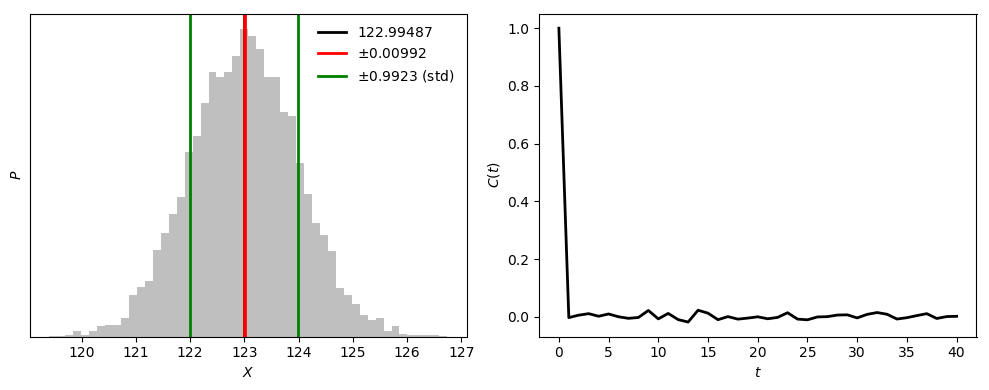

In [168]:
plot_error(X, binsize=1, digits=5);

In [169]:
iswithinerrorbars(123., mean(X), Y[end],true)

true

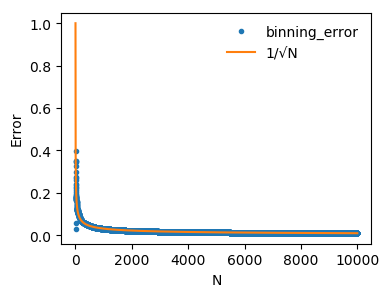

PyObject <matplotlib.legend.Legend object at 0x00000000314F3BE0>

In [170]:
using PyPlot
figure(figsize=(4,3))
plot(N,Y,".",label="binning_error")
plot(N,1./sqrt.(N), label="1/√N")
xlabel("N")
ylabel("Error")
legend(frameon=false)
# savefig("binning_error_uncorrelated.pdf")

In [171]:
isapprox(jackknife_error(mean,X,binsize=1), binning_error(X, binsize=1))

true

In [172]:
using BenchmarkTools
@btime binning_error(X, binsize=10);
@btime jackknife_error(mean,X,binsize=10);

  31.146 μs (2009 allocations: 86.36 KiB)
  3.422 ms (4013 allocations: 15.60 MiB)


## Data: complex numbers

We use the same definition for error of complex data as `std` in Julia: we calculate errors of real and imaginary parts and take the norm of this error vector as the real error of the complex input, i.e: $\left|\begin{pmatrix} \text{real_error} \\ \text{imag_error} \end{pmatrix}\right|$

## Data: real arrays

In [103]:
function f(N_max)
    X = Vector{Array{Float64,2}}(N_max)
    N = Vector{Int}(N_max)
    Y = Vector{Array{Float64,2}}(N_max)
    Xorig = [1 2 3; 4 5 6] * 100
    @inbounds for i in 1:N_max
        N[i] = i
        X[i] = Xorig + randn(2,3)
        Y[i] = @views binning_error(X[1:i], binsize=1)
    end
    return Xorig,X,N,Y
end

f (generic function with 1 method)

In [104]:
Xorig,X,N,Y = f(100);

In [105]:
iswithinerrorbars(Float64.(Xorig), mean(X), Y[end],true)
# not always true, since std only 68% confidence
# take two-sigma: 95 or three-sigma: 99.7%

2×3 Array{Float64,2}:
 0.0  0.0  0.5912
 0.0  0.0  0.0   

A ≈ B + K.*Δ, where K is:


false

In [106]:
jackknife_error(mean,X,binsize=1)

LoadError: [91mJackknife error calculation for array like data not yet supported.[39m

## Data: complex arrays

In [115]:
function f(N_max)
    X = Vector{Array{Complex128,2}}(N_max)
    N = Vector{Int}(N_max)
    Y = Vector{Array{Float64,2}}(N_max)
    Xorig = [1 2 3; 4 5 6] * 100
    @inbounds for i in 1:N_max
        N[i] = i
        X[i] = Xorig + randn(2,3) + randn(2,3)*im
        Y[i] = @views binning_error(X[1:i], binsize=1)
    end
    return Xorig,X,N,Y
end

f (generic function with 1 method)

In [135]:
Xorig,X,N,Y = f(1000);

In [136]:
#Example datapoint:
X[1]

2×3 Array{Complex{Float64},2}:
 98.9064+0.286171im   199.49-0.718201im  300.054+1.37449im 
 398.593+1.04961im   501.011-0.121259im  600.786+0.521081im

In [138]:
println(iswithinerrorbars(Float64.(Xorig), mean(X), Y[end]))
println(iswithinerrorbars(Float64.(Xorig), mean(X), 2*Y[end]))
println(iswithinerrorbars(Float64.(Xorig), mean(X), 3*Y[end]))
# not always true, since std only 68% confidence
# take two-sigma: 95 or three-sigma: 99.7%

false
true
true


# Correlated data: 2D Ising model magnetization

In [1]:
using HDF5
using ErrorAnalysis
using PyPlot

Number of measurements: 50000


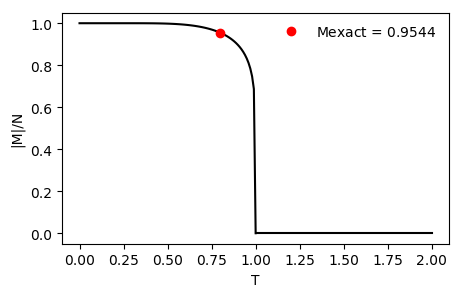

In [2]:
fname = "Ising2D_L20_T0.8.h5"
Mtot = abs.(h5read(fname, "magnetization"))[2:end]
L = h5read(fname, "L")
N = L^2
T = h5read(fname, "T")
println("Number of measurements: ", length(Mtot))
sleep(.1) # ugly hack
M = Mtot/N

Tc = 1/(1/2*log(1+sqrt(2)))
if T<=1.0
    global const Mexact = (1-sinh(2.0/(T*Tc))^(-4))^(1.0/8.0)
else
    global const Mexact = 0.0
end

x = linspace(0.0, 1.0, 100)
y = (1-sinh.(2.0 ./ (x*Tc)).^(-4)).^(1/8)
figure(figsize=(5,3))
plot(x,y,"k")
plot(linspace(1.0, 2.0, 100), zeros(100), "k")
plot([T], Mexact, "ro", label="Mexact = \$ $(round(Mexact,4)) \$ ")
xlabel("T")
legend(frameon=false, loc="best")
ylabel("|M|/N");

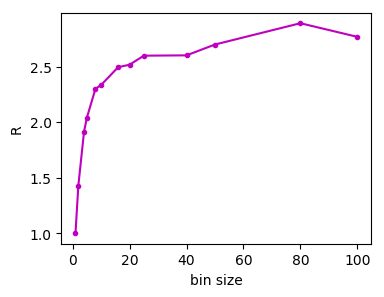

PyPlot not loaded. Loading it now...


In [3]:
plot_binning_R(M);
# Should reach a plateau, otherwise N isn't large enough -> need more samples.
# Start of plateau is good choice for binsize -> here e.g. binsize=25 or so.
# (Strange behavior for larger bin sizes is normal)

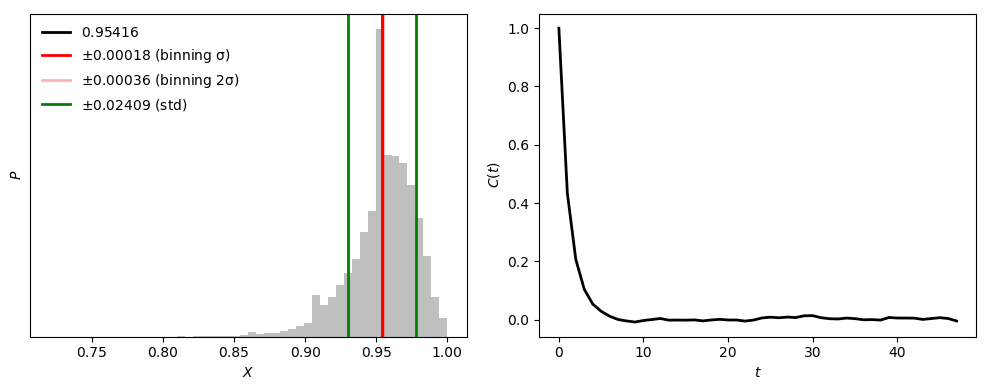

In [4]:
plot_error(M, digits=5);

In [5]:
# Integrated autocorrelation time: we indeed have correlated data (τ>1)
ErrorAnalysis.tau_integrated(M)

2.415080519923406

In [6]:
# If we bin the data we get effective independent datapoints (τ_bins ≈ 1)
ErrorAnalysis.tau_integrated(M[1:ErrorAnalysis.Neff_binning(M, binsize=25):end])

1.0

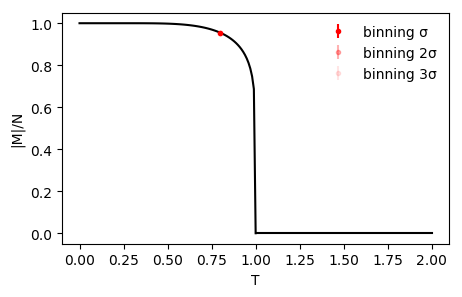

In [7]:
figure(figsize=(5,3))

# exact (analytic result)
x = linspace(0.0, 1.0, 100)
Mag(x) = (1-sinh.(2.0 ./ (x*Tc)).^(-4)).^(1/8)
plot(x,Mag(x),"k")
plot(linspace(1.0, 2.0, 100), zeros(100), "k")

# numerical datapoint with (tiny tiny) one and two sigma errorbar
errorbar([T], mean(M), yerr=binning_error(M, binsize=25),  fmt="r.", label="binning σ")
errorbar([T], mean(M), yerr=2*binning_error(M, binsize=25),  fmt="r.", alpha=.3, label="binning 2σ")
errorbar([T], mean(M), yerr=3*binning_error(M, binsize=25),  fmt="r.", alpha=.1, label="binning 3σ")

xlabel("T")
legend(frameon=false, loc="best")
ylabel("|M|/N");

## 50000 datapoints (zoomed in)

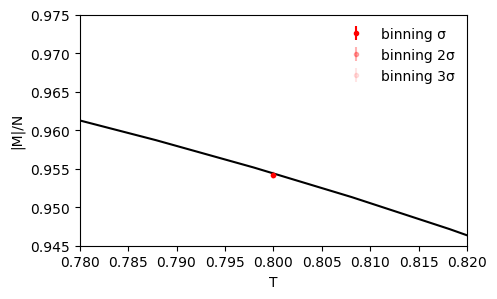

(0.945, 0.975)

In [8]:
figure(figsize=(5,3))

# exact (analytic result)
x = linspace(0.0, 1.0, 100)
Mag(x) = (1-sinh.(2.0 ./ (x*Tc)).^(-4)).^(1/8)
plot(x,Mag(x),"k")
plot(linspace(1.0, 2.0, 100), zeros(100), "k")

# numerical datapoint with (tiny tiny) one and two sigma errorbar
errorbar([T], mean(M), yerr=binning_error(M, binsize=25),  fmt="r.", label="binning σ")
errorbar([T], mean(M), yerr=2*binning_error(M, binsize=25),  fmt="r.", alpha=.3, label="binning 2σ")
errorbar([T], mean(M), yerr=3*binning_error(M, binsize=25),  fmt="r.", alpha=.1, label="binning 3σ")

xlabel("T")
legend(frameon=false, loc="best")
ylabel("|M|/N");
xlim([.78, .82])
ylim([0.945, 0.975])

In [10]:
# check if in two-sigma interval
println(iswithinerrorbars(Mag(T), mean(M), binning_error(M, binsize=25)))
println(iswithinerrorbars(Mag(T), mean(M), 2*binning_error(M, binsize=25)))
println(iswithinerrorbars(Mag(T), mean(M), 3*binning_error(M, binsize=25)))

false
true
true


## 100 datapoints (zoomed in)

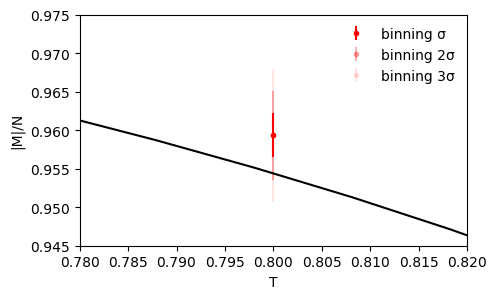

(0.945, 0.975)

In [14]:
M = Mtot[1:100]/N;
figure(figsize=(5,3))

# exact (analytic result)
x = linspace(0.0, 1.0, 100)
Mag(x) = (1-sinh.(2.0 ./ (x*Tc)).^(-4)).^(1/8)
plot(x,Mag(x),"k")
plot(linspace(1.0, 2.0, 100), zeros(100), "k")

# numerical datapoint with (tiny tiny) one and two sigma errorbar
errorbar([T], mean(M), yerr=binning_error(M, binsize=25),  fmt="r.", label="binning σ")
errorbar([T], mean(M), yerr=2*binning_error(M, binsize=25),  fmt="r.", alpha=.3, label="binning 2σ")
errorbar([T], mean(M), yerr=3*binning_error(M, binsize=25),  fmt="r.", alpha=.1, label="binning 3σ")

xlabel("T")
legend(frameon=false, loc="best")
ylabel("|M|/N");
xlim([.78, .82])
ylim([0.945, 0.975])

In [13]:
# check if in two-sigma interval
println(iswithinerrorbars(Mag(T), mean(M), binning_error(M, binsize=25)))
println(iswithinerrorbars(Mag(T), mean(M), 2*binning_error(M, binsize=25)))
println(iswithinerrorbars(Mag(T), mean(M), 3*binning_error(M, binsize=25)))

false
true
true
